#  Supervised Learning - Decision Tree and Random Forest


This colab notebook is an introduction to Decision Tree and Random Forest.

### Decision Tree - Classification

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from subprocess import call
import pydotplus
from IPython.display import Image

In [0]:
!mkdir dataset

Archive:  titanic.zip
  inflating: train.csv               
  inflating: test.csv                
  inflating: gender_submission.csv   


In [0]:
# Download the titanic dataset from Kaggle & Load it
path = 'dataset/'
df=pd.read_csv(path+'train.csv')

Let's take a portion of dataset to better illustrate how Decision Tree modeling approach works

In [0]:
test_df = df[['Sex','Age','Survived']].iloc[[1,2,889,890]].reset_index(drop = True)
test_df

,Sex,Age,Survived
0,female,38.0,1
1,female,26.0,1
2,male,26.0,1
3,male,32.0,0


In [0]:
X = pd.get_dummies(test_df[['Sex','Age']],drop_first = True)
Y = test_df['Survived']

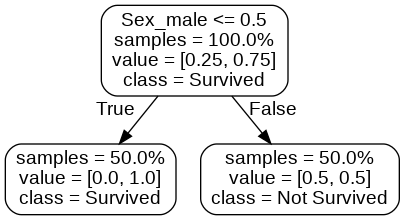

In [0]:
dt = DecisionTreeClassifier(max_depth=1)
dt.fit(X,Y)
# Export as dot file
dot_data = export_graphviz(dt, out_file=None, 
                        feature_names = X.columns,
                        class_names = ['Not Survived','Survived'],
                        rounded = True, proportion = True, 
                        precision = 2, filled = False, impurity = False)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

So decision tree splits the data into two _nodes_. If passenger is a female, she falls into left node, while if passenger is a male he falls into right node. As we can see if passenger is a female she survives, while male passengers have kind of 50/50 chance to survive according to our small dataset. Decision Tree can also be expanded at its nodes.

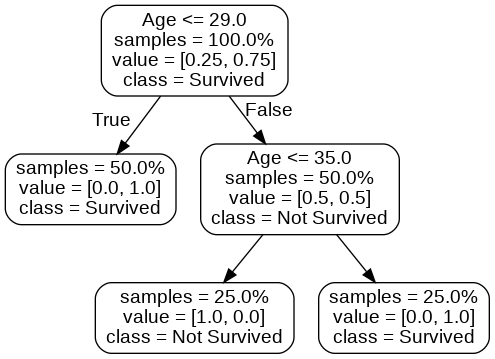

In [0]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X,Y)
# Export as dot file
dot_data = export_graphviz(dt, out_file=None, 
                        feature_names = X.columns,
                        class_names = ['Not Survived','Survived'],
                        rounded = True, proportion = True, 
                        precision = 2, filled = False, impurity = False)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

I this case Age is also incorporated.

To effectively make splits Decision Trees use notion of information (Entrophy, Gini Impurity). The idea is to compare all possible splits and take the one which gives the "most" information.

Let's define Entophy and Gini Impurity.<br>
_Note: in practice Gini Impurity is used as it is less computationally intensive_

Entrophy
$$Entrophy = -\sum\limits_i^kp_ilog_k(p_i),$$ where $p_i$ is the probability of $i$-th class

For binary case:
$$Entrophy = -plog_2(p)-(1-p)log_2(1-p)$$

Gini Impurity
$$Gini = 1-\sum\limits_i^kp_i^2,$$ where $p_i$ is the probability of $i$-th class

And for binary case:
$$Gini = 1-p^2-(1-p)^2$$

In [0]:
x_axis = np.linspace(0,1,1000)
entrophy_2class = -x_axis*np.log(x_axis)/np.log(2) - (1-x_axis)*np.log(1-x_axis)/np.log(2)
gini_2class = 1-x_axis**2-(1-x_axis)**2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


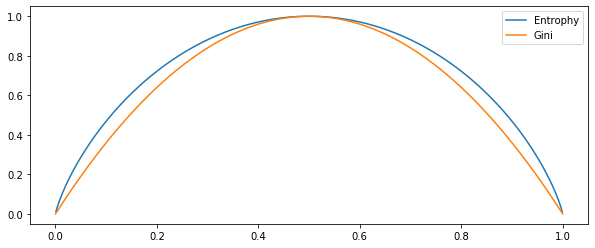

In [0]:
plt.figure(figsize = (10,4))
plt.plot(x_axis,entrophy_2class,label = 'Entrophy')
plt.plot(x_axis,2*gini_2class, label = 'Gini') # scale to see similarity
plt.legend()
plt.show()

So Gini is a little less conservative than Entrophy. Both are at thier max when the probability is 0.5,0.5 i.e. when data is uniformly distributed. And both decrease as randomity in data decreases.

After computing Gini impurity for the dataset , we should pick a split and calculated weighted Gini impurities for each portion of dataset. After that we should calcualte _information gain_, i.e. how much randomness is dropped out after the split.

Information Gain:
$$IG = Gini_{root}-\frac{s_1}{s_1+s_2}Gini_{left node}-\frac{s_2}{s_1+s_2}Gini_{right node}$$

But First lets calculate the gini impurity of whole dataset. We have 3 survivors out of 4, thus

In [0]:
surv_p = 3/4
not_surv_p = 1/4
gini = 1-(3/4)**2-(1/4)**2
gini

0.375

Let's split dataset by column Sex

In [0]:
test_df_female = test_df[test_df['Sex'] == 'female']
test_df_female

,Sex,Age,Survived
0,female,38.0,1
1,female,26.0,1


In [0]:
test_df_male = test_df[test_df['Sex'] == 'male']
test_df_male

,Sex,Age,Survived
2,male,26.0,1
3,male,32.0,0


And calculate Gini Impurities for each one

In [0]:
gini_female = 1 - 1**2-0**2
gini_male = 1 - (1/2)**2-(1/2)**2
print(gini_female,gini_male)

0 0.5


And now we should weight resulting impurities with sample size and calculate how much information we gained via this split.

In [0]:
weigthed_gini = 1/2*0+1/2*1/2
information_gain = gini-weigthed_gini
information_gain

0.125

To decide most effective split we need to do these calculation for each split and pick the one which has most information gain.

In case of numerical data like Age, there are several option for all possible splits. The simple approach is to sort that feature and take as splits the middlepoints for each consecutive pair. Other approach is to split data in some percentiles to not test too many splits.

Now plotting tree with gini impurity we can see our calculations.

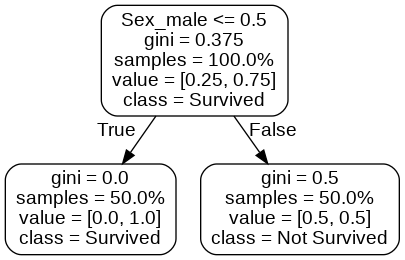

In [0]:
dt = DecisionTreeClassifier(max_depth=1)
dt.fit(X[['Sex_male']],Y)
# Export as dot file
dot_data = export_graphviz(dt, out_file=None, 
                        feature_names = ['Sex_male'],
                        class_names = ['Not Survived','Survived'],
                        rounded = True, proportion = True, 
                        precision = 3, filled = False, impurity = True)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

Now let's make a tree with whole titanic dataset with some additional columns

In [0]:
df_wo_nan = df[['Sex','Age','Fare','Survived']].dropna().reset_index(drop = True)
X = pd.get_dummies(df_wo_nan[['Sex','Age','Fare']],drop_first = True)
Y = df_wo_nan['Survived']

dt = DecisionTreeClassifier(max_depth=None)
dt.fit(X,Y)
# Export as dot file
dot_data = export_graphviz(dt, out_file=None, 
                        feature_names = X.columns,
                        class_names = ['Not Survived','Survived'],
                        rounded = True, proportion = True, 
                        precision = 2, filled = False, impurity = True)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png(),width=600, height=300)

Output hidden; open in https://colab.research.google.com to view.

Growing deep trees imposes a risk of overfitting. To combat it we can restrict the tree not to grow deeper nodes, or restric by number of nodes, or by increasing minimum number of samples in the node and some other methods. Sklearn `DecisionTreeClassifier` provides those options in its implementation. 

Now let's see how Decision Tree boundaries are mapped on a 2D

In [0]:
from decision_areas import decision_areas, plot_areas

Credit to: https://stackoverflow.com/questions/43929400/retrieve-decision-boundary-lines-x-y-coordinate-format-from-sklearn-decision-t

In [0]:
# check limiits of variables
X.describe()

,Age,Fare,Sex_male
count,714.000000,714.000000,714.000000
mean,29.699118,34.694514,0.634454
std,14.526497,52.918930,0.481921
min,0.420000,0.000000,0.000000
25%,20.125000,8.050000,0.000000
50%,28.000000,15.741700,1.000000
75%,38.000000,33.375000,1.000000
max,80.000000,512.329200,1.000000


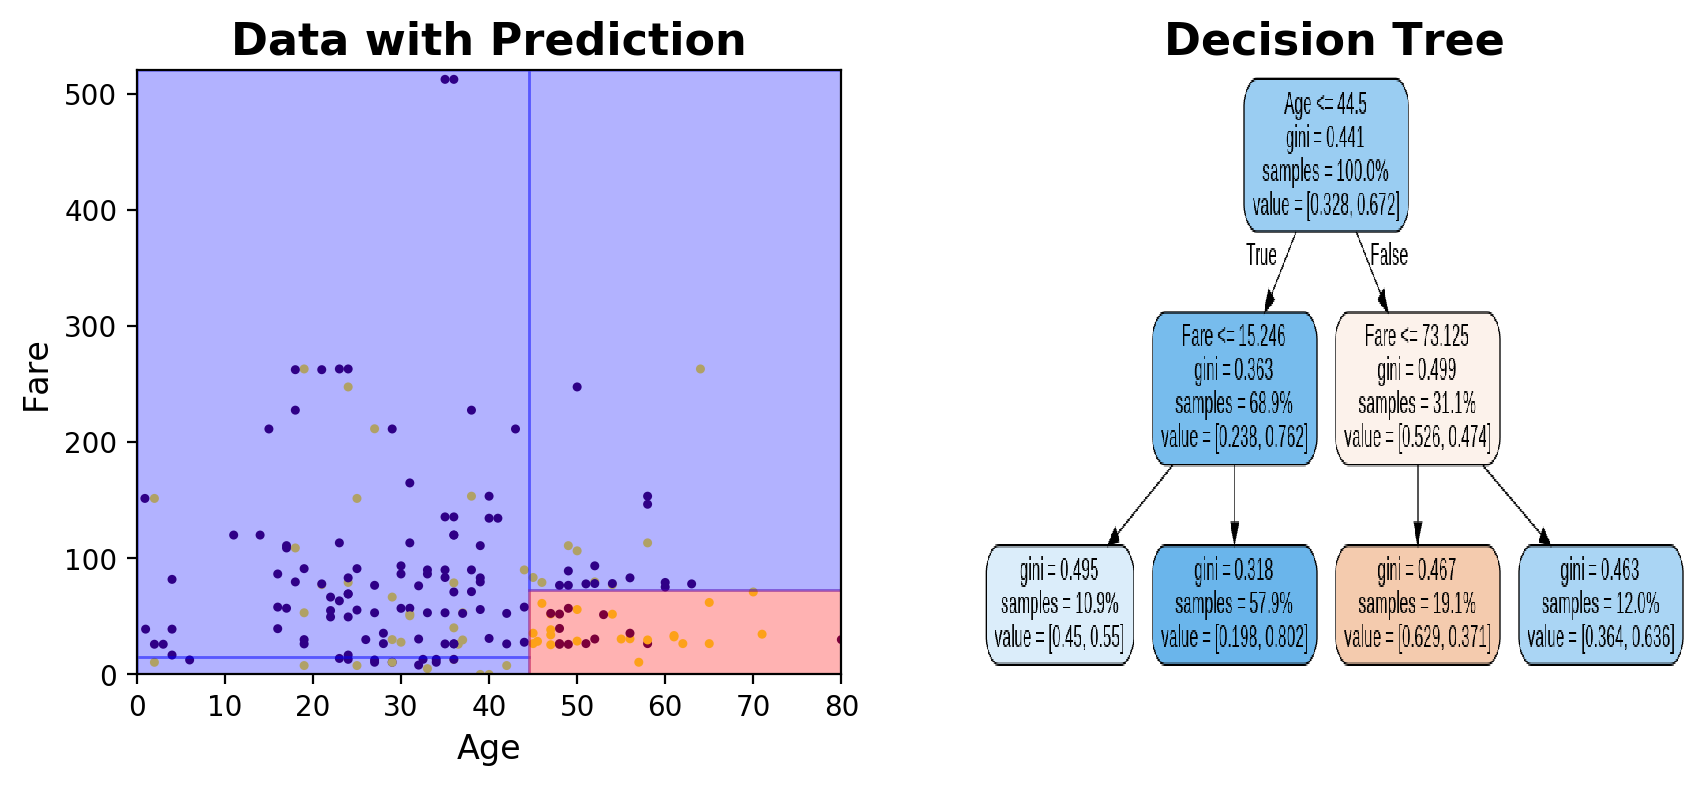

In [0]:
df_wo_nan = df.dropna().reset_index(drop = True)
X = pd.get_dummies(df_wo_nan[['Age','Fare']],drop_first = True)
Y = df_wo_nan['Survived']

dt = DecisionTreeClassifier(max_depth=2,min_samples_leaf=20)
dt.fit(X,Y)

dot_data = export_graphviz(dt, out_file=None, 
                        feature_names = ['Age','Fare'],
                        rounded = True, proportion = True, 
                        precision = 3, filled = True,
                        impurity = True)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  
graph.write_png('tree.png')
im = plt.imread('tree.png')

fig,axes = plt.subplots(1,2, figsize=(10,4), dpi = 200)
rectangles = decision_areas(dt, [0, 80, 0, 520])
axes[0].scatter(X['Age'],X['Fare'], c = 1-Y,s = 5)
plot_areas(rectangles,axes[0])
axes[0].set_xlim(0,80)
axes[0].set_ylim(0,520)
axes[0].set_xlabel('Age',fontsize = 12)
axes[0].set_ylabel('Fare',fontsize = 12)

axes[0].set_title('Data with Prediction', fontsize = 16, fontweight="bold")
axes[1].imshow(im, aspect='auto')
axes[1].set_title('Decision Tree', fontsize = 16, fontweight="bold")
axes[1].axis('off')

plt.show()

### Decision Tree - Regression

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from subprocess import call
import pydotplus
from IPython.display import Image
import matplotlib.image as mpimg

In [0]:
means = [2,6,4,9,1]
X = [i for i in range(50)]
Y = []
for m in means:
    for i in range(10):
        Y.append(np.random.random()+m)

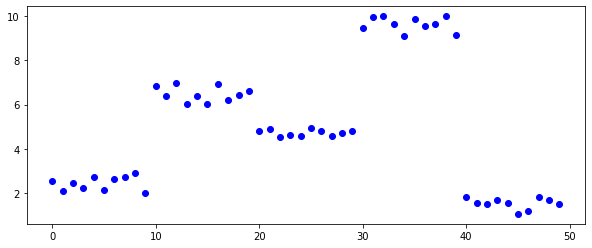

In [0]:
plt.figure(figsize = (10,4))
plt.plot(X,Y,'bo')
plt.show()

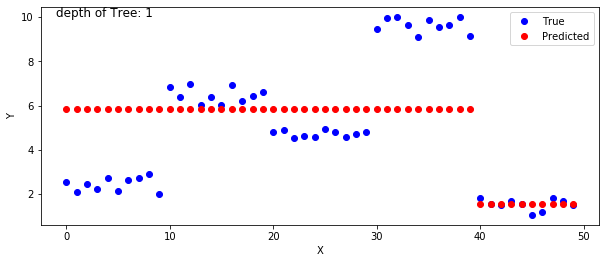

In [0]:
X = np.array(X).reshape(-1, 1)
dt = DecisionTreeRegressor(max_depth=1, min_samples_split = 11)
dt.fit(X,Y)
y_pred = dt.predict(X)
plt.figure(figsize = (10,4))
plt.plot(X,Y,'bo', label = 'True')
plt.plot(X,y_pred,'ro', label = 'Predicted')
plt.text(-1, 10, 'depth of Tree: '+ str(dt.max_depth), fontsize=12)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

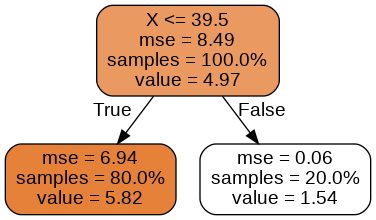

In [0]:
dot_data = export_graphviz(dt, out_file=None, 
                        feature_names = ['X'],
                        rounded = True, proportion = True, 
                        precision = 2, filled = True,
                        impurity = True)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())


In [0]:
X = np.array(X).reshape(-1, 1)
dt = DecisionTreeRegressor(max_depth=2, min_samples_split = 2)
dt.fit(X,Y)
y_pred = dt.predict(X)


dot_data = export_graphviz(dt, out_file=None, 
                        feature_names = ['X'],
                        rounded = True, proportion = True, 
                        precision = 3, filled = True,
                        impurity = True)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  
graph.write_png('tree.png')
im = plt.imread('tree.png')

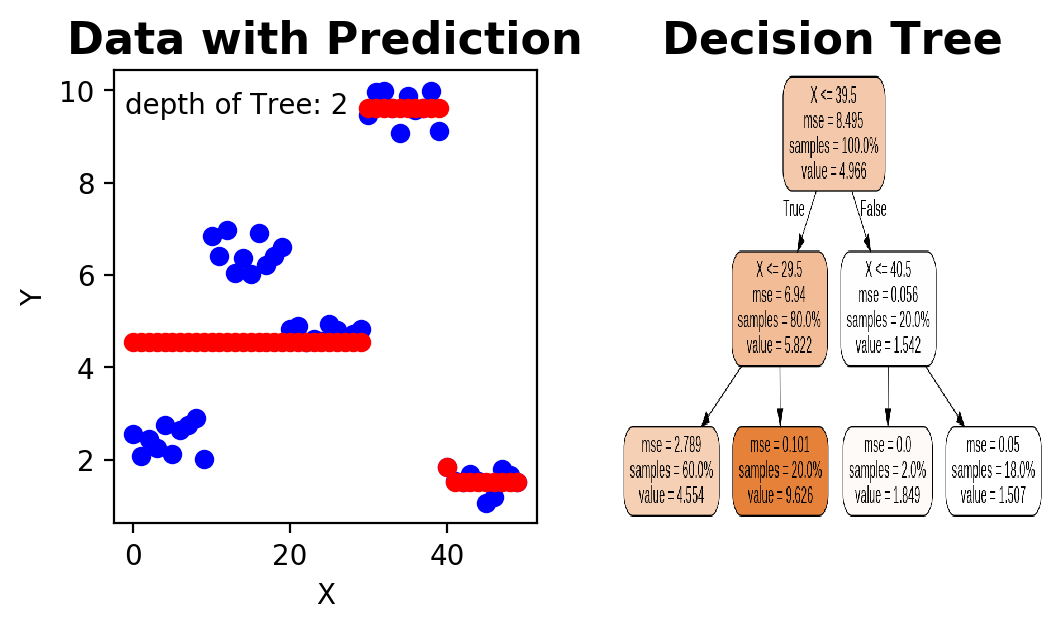

In [0]:
fig,axes = plt.subplots(1,2, figsize=(6,3), dpi = 200)
axes[0].plot(X,Y,'bo', label = 'True')
axes[0].plot(X,y_pred,'ro', label = 'Predicted')
axes[0].text(-1, 9.5, 'depth of Tree: '+ str(dt.max_depth), fontsize=10)
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].set_title('Data with Prediction', fontsize = 16, fontweight="bold")
axes[1].imshow(im, aspect='auto')
axes[1].set_title('Decision Tree', fontsize = 16, fontweight="bold")
axes[1].axis('off')
plt.show()

In regression tree as information we use Variance (MSE equivalently).

$$VAR = \frac{1}{n}\sum\limits_{i=1}^{n}(y_i-\bar y)^2$$

Information gain with Variance will have the following form:
$$IG = \frac{1}{n}(\sum\limits_{i\in root}(y_i-\bar{y})^2-\sum\limits_{i\in left}(y_i-\bar{y_l})^2-\sum\limits_{i\in right}(y_i-\bar{y_r})^2)$$

### **Task**: 
**Derive the information gain above**

### Random Forest

Bootstraping 101: https://pdfs.semanticscholar.org/190b/d7b8ac8b32f549756fecec2f42c8521b94ea.pdf

Random Forests paper: https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf

Random Forests is a model constructed from many Decision Trees. To construct each Tree differently some randomizations are applied. First is **Bootstraping** technique. Bootstraping is a general technique which can be applied to any model. The idea is to uniformly resample data with replacement some K times and make K models and test them on parts of data which were not resampled. The intuition here is like population-sample pair, but in this case sample is acting the role of population, while resampled data is acting the role of a sample. Each resampled dataset will leave about 1/3-rd out.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from subprocess import call
import pydotplus
from IPython.display import Image

In [0]:
# Simulation of bootstraped dataset
test = [i for i in range(10)]
boot = np.random.choice(test,len(test))

In [0]:
test,boot

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], array([5, 3, 1, 2, 4, 5, 1, 6, 4, 3]))

Another randomization (probably most important) is that on each split a random subset of features are considered only. This way it is guaranteed that Decision Trees will be very different from each other. 

After fitting say 100 trees, the results are combined together (This is called Bagging = Bootsrtap Aggregating). For classification Usually a mojirty voting is used and for regression mean of outputs is taken.

![alt text](https://www.researchgate.net/profile/Evaldas_Vaiciukynas/publication/301638643/figure/fig1/AS:355471899807744@1461762513154/Architecture-of-the-random-forest-model.png)

Random forest is an example of **ensemble learning**, in which results from multiple different models are averaged in some sense.

In [0]:
# Download the titanic dataset from Kaggle & Load it
path = 'dataset/'
df=pd.read_csv(path+'train.csv')

In [0]:
df_wo_nan = df[['Sex','Age','Fare','Survived','Embarked']].dropna().reset_index(drop = True)
X = pd.get_dummies(df_wo_nan[['Sex','Age','Fare','Embarked']])
Y = df_wo_nan['Survived']

In [0]:
rf = RandomForestClassifier(n_estimators=200, max_depth=2)
rf.fit(X,Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
rf.estimators_

[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                        max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=7991572, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                        max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=1555326149, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                        max_features='auto', max_leaf_nodes=None,
                        min_i

In [0]:
dt0 = rf.estimators_[0]
dt1 = rf.estimators_[1]

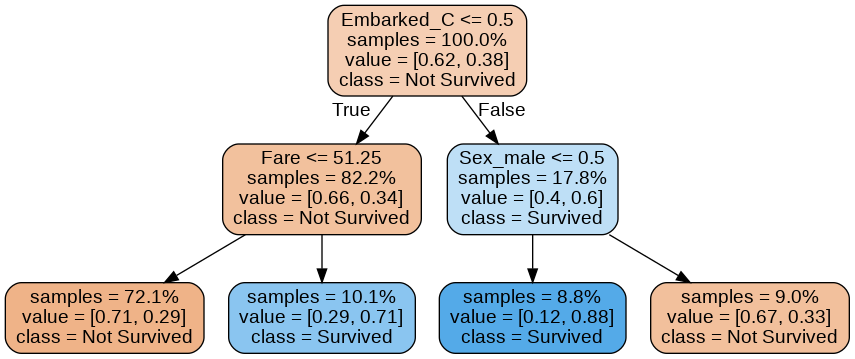

In [0]:
# First Tree in Random Forests
dot_data = export_graphviz(dt0, out_file=None, 
                        feature_names = X.columns,
                        class_names = ['Not Survived','Survived'],
                        rounded = True, proportion = True, 
                        precision = 2, filled = True, impurity = False)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

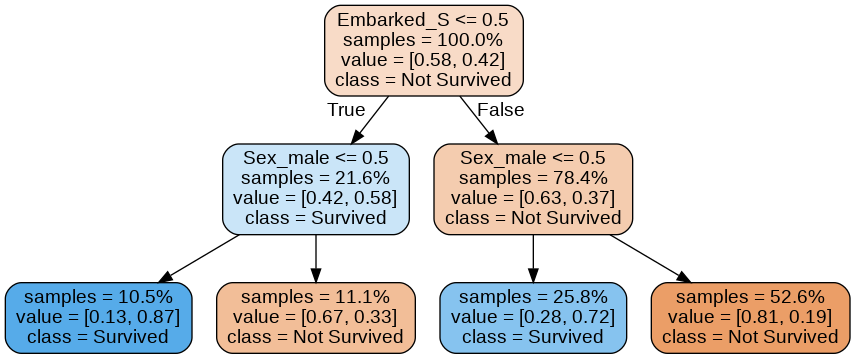

In [0]:
# Second Tree in Random Forests
dot_data = export_graphviz(dt1, out_file=None, 
                        feature_names = X.columns,
                        class_names = ['Not Survived','Survived'],
                        rounded = True, proportion = True, 
                        precision = 2, filled = True, impurity = False)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

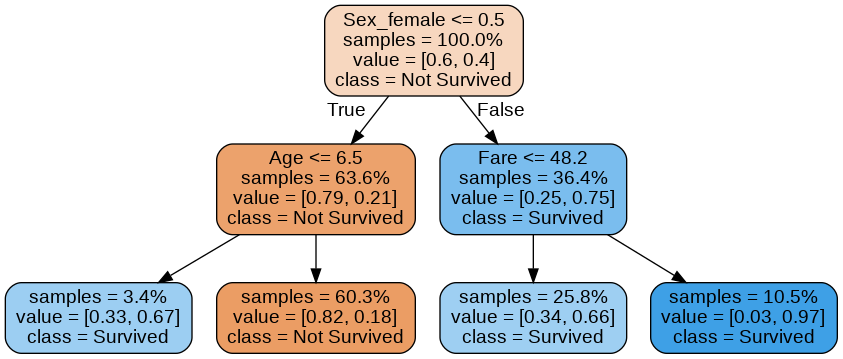

In [0]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X,Y)
dot_data = export_graphviz(dt, out_file=None, 
                        feature_names = X.columns,
                        class_names = ['Not Survived','Survived'],
                        rounded = True, proportion = True, 
                        precision = 2, filled = True, impurity = False)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

# Exercise 1

Check what percentage of data is left out on average from bootsraping (100 times) when $n = 10,100,1000,10000$. 

In [0]:
def simulate_bootstrap(size, iter):
  perc = []
  for i in range(iter):
    test = [j for j in range(size)]
    boot = np.random.choice(test, len(test))
    boot = boot.tolist()

    same = list(set(test).intersection(boot))
    same_cnt = len(same)
    perc.append(same_cnt / len(test))

  left_out = 1 - np.mean(perc)
  
  return left_out

In [0]:
simulate_bootstrap(100000, 100)

0.36791719999999994

# Exercise 2

Build Logistic Regression, Decision Tree and Random Forest on titanic data. Compare them with ROC AUC score on test set.